<a href="https://colab.research.google.com/github/adasegroup/ML2022_seminars/blob/master/seminar7/seminar_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar: Gradient Boosting
Course: Machine Learning by professor Evgeny Burnaev
<br>
Author: Alexander Marusov

### Main statements about Decision Trees, Bagging and Random Forests.

- **DECISION TREES**. 
With increasing the *max_depth* parameter the training loss of decision tree will be closer to zero, but test loss is high. This means, that our model has bad generalization capability and we have **overfitting**. Consequently, we need somehow to prevent overfitting. Of course we can choose the best *max_depth* parameter according to test, but it is not the only solution.

- **BAGGING = DECISION TREE + BOOTSTRAP**. 
We can use several decision trees, which are trained on different train sets, which were received using bootstrap procedure. Bootsrapped dataset contains the same number of samples as original data but some of them are included with some number of their copies, and some of them are not included. To make a final prediction we will average predictions across decision trees. Since we will have different trees, the predictions will be more or less independent and, consequently, overfitting will be decreased.

- **RANDOM FOREST = BAGGING + DIFFERENT FEATURES**.
To increase generalization capability of the model (by making assumption about independency of trees stronger) we want to take not only different samples, but also different features as well. In Random Forest we have several decision trees, which are trained not only on different train samples, but also on different features as well.

The main disadvantage of the ensembles above is that the learning process is undirected, i.e. decision trees don't know anything about mistakes of the others models. To eliminate this problem we will try the **Boosting** idea.

### The problem statement


The solution is found in the form of sum over random trees $h_m(x)$,
$$F(x) = \sum_{m=1}^{M} h_m(x).$$

The additive model is built in a greedy fashion:
$$f_m(x) = f_{m-1}(x) + h_m(x).$$

Having loss function $L(y, f)$, we find every new tree from the optimization
$$h_m =  \arg\min_{h} \sum_{i=1}^{n} L(y_i, f_{m-1}(x_i) + h(x_i)).$$









### How the problem is solved


The initial model $f_0(x)$ is problem specific, for least-squares regression one usually chooses the mean of the target values.

To solve the task above we should divide into two parts:

- At the beggining we should find values $s_i$, which our random trees should have on the data $x_i$, i.e. $s_i = h(x_i)$. To solve this task we should find minimum of $F(s):$
$$F(s) =  \sum_{i=1}^{n} L(y_i, f_{m-1}(x_i) + s_i)).$$ Here $s = (s_1, s_2, ... , s_n)$. As we know from the math, the gradient of the function will show the direction of the highest increase of the function. Since we want to minimize the function, we should go in the direction, which is opposite to the gradient. This direction is also-called **antigradient**. Currently $s = (0, 0, ... , 0)$, because $$F(0) =  \sum_{i=1}^{n} L(y_i, f_{m-1}(x_i)))$$ So we need to make a gradient step from fucntion $F$ in point $s = (0, 0, ... , 0)$. The gradient step is the next formula: $$s_{new} = s_{old} - \nabla F(s)|_{s=s_{old}}$$ Since $s_{old} = (0, 0, ... , 0)$, the components of new vector $s$ should be: $$s_{new_i} = -\frac{\partial L(y_i, f_{m-1}(x_i))}{\partial f_{m-1}(x_i)}.$$

- After that we can find $h_m(x)$ just by solving usual supervised learning task with the data $(x_1, s_1), (x_2, s_2), ..., (x_n, s_n)$.


Before the final step in some versions of Gradient Boosting you should find $$\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, f_{m-1}(x_i)
- \gamma \frac{\partial L(y_i, f_{m-1}(x_i))}{\partial f_{m-1}(x_i)})$$ Finally, $$f_m(x) = f_{m-1}(x) + \nu \gamma_m h_m(x)$$



Also there can be just simple sum $f_m(x) = f_{m-1}(x) + h_m(x)$

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

## Gradient Boosting for classification.

**Task:** We should predict probability that somebody will experience financial distress in the next two years given some characteristics. So we have **binary classification**. The target variable is **SeriousDlqin2yrs**

The data was taken from https://www.kaggle.com/c/GiveMeSomeCredit

The description of variables you can find also here https://www.kaggle.com/c/GiveMeSomeCredit

### 1. EDA and Data preprocessing

In [10]:
rand_state = 123

In [11]:
df_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2022_seminars/master/seminar5/give_me_some_credit.csv', index_col=0)

In [12]:
df_kaggle_test = pd.read_csv('https://raw.githubusercontent.com/Astralex98/Give-me-some-credit-Kaggle-/main/cs-test.csv', index_col=0)

In [13]:
df_kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtype

In [14]:
# There are no any labels in test, so we just remove this column
df_kaggle_test = df_kaggle_test.drop(['SeriousDlqin2yrs'], axis=1)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [16]:
# Check for imbalance
df_train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

**Summary of quick EDA:**

1. There are some missing values

2. Our classification task is highly imbalanced

#### 1.1 Missing values

Since random forests can't deal with NaNs, we should somehow deal with them. More about strategies for dealing with missing values you can find [here](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)

We can see, that features **MonthlyIncome** (20%) and **NumberOfDependents** (3%) have some missing values. From our intuition we can understand that **MonthlyIncome** is highly important feature for our task. Consequently, dropping those data-points could be a not a good idea. Now, for the sake of simplicity, we can just impute NaNs with means of corresponding features.

In [22]:
# Method to preprocess data
def df_remove_nans(df):

    # Deal with NaNs
    df["MonthlyIncome"] = df["MonthlyIncome"].replace(np.NaN,  df["MonthlyIncome"].mean())
    df["NumberOfDependents"] = df["NumberOfDependents"].replace(np.NaN,  df["NumberOfDependents"].mean())

    # small check for NaNs
    if ((df["MonthlyIncome"].isnull().values.any() == True) or (df["NumberOfDependents"].isnull().values.any())):
        print("There are some NaNs here!")
        return None

    return df

In [23]:
# remove nans data
df_train = df_remove_nans(df_train)
X_kaggle_test = df_remove_nans(df_kaggle_test)

### 2. Dividing data into train and test

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['SeriousDlqin2yrs'], axis=1), 
                                                    df_train['SeriousDlqin2yrs'], 
                                                    test_size = 0.3, 
                                                    random_state=rand_state, 
                                                    shuffle = True)

In [31]:
 # use only each 10th sample to save time
X_train = X_train.iloc[::10, :]
y_train = y_train.iloc[::10]

In [32]:
n_features = X_train.shape[1]

### 3. Training

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
clf = GradientBoostingClassifier(random_state=rand_state)

In [36]:
param_grid = {'n_estimators' : [20, 30, 40],
              'max_depth': [2, 5, 7, 9],
              'max_features': ['log2', 'sqrt', n_features],
              'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]}

In [37]:
clf = RandomizedSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_iter = 10, random_state = rand_state)

In [38]:
%%time
clf.fit(X_train, y_train)

CPU times: user 2.52 s, sys: 20.5 ms, total: 2.55 s
Wall time: 2.54 s


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=123),
                   param_distributions={'learning_rate': [0.05, 0.075, 0.1,
                                                          0.25, 0.5, 0.75, 1],
                                        'max_depth': [2, 5, 7, 9],
                                        'max_features': ['log2', 'sqrt', 10],
                                        'n_estimators': [20, 30, 40]},
                   random_state=123, scoring='roc_auc')

### 4. Feature importance and feature selection

**1. Feature selection**

We try to find the most important features.

**2. Dimensionality reduction**

We have a lot of useful features and for some reasons we want to reduce the number of used features.

**3. Feature generation**

We want to create a feature description for an object (e.g. image).
Earlier scientists used some handcrafted features (e.g. HoG). Now neural networks create features automatically.



In [39]:
from sklearn.feature_selection import SelectFromModel

In [40]:
# Fit model using each importance as a threshold
model = clf.best_estimator_

# Weights of each feature are thresholds
thresholds = sorted(model.feature_importances_)

In [41]:
# Here we collect the auc score for corresponding set of features, whos importance
# is higher than a current threshold
aucs_list = []

In [42]:
%%time
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    # train model
    new_clf = GradientBoostingClassifier(random_state=rand_state)
    new_clf.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_predict_proba = new_clf.predict_proba(select_X_test)
    roc_auc = roc_auc_score(y_test, y_predict_proba[:, 1])
    aucs_list.append((thresh, select_X_train.shape[1], roc_auc))

/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature nam

CPU times: user 1.1 s, sys: 13.1 ms, total: 1.12 s
Wall time: 1.12 s


/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/polina/miniforge3/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [44]:
for elem in aucs_list:
    thresh, num_features, roc_auc = elem
    print("Thresh=%.3f, n=%d, AUC: %.5f" % (thresh, num_features, roc_auc))

Thresh=0.044, n=10, AUC: 0.83961
Thresh=0.049, n=9, AUC: 0.83624
Thresh=0.085, n=8, AUC: 0.83761
Thresh=0.086, n=7, AUC: 0.82230
Thresh=0.087, n=6, AUC: 0.82058
Thresh=0.095, n=5, AUC: 0.81960
Thresh=0.116, n=4, AUC: 0.80752
Thresh=0.123, n=3, AUC: 0.79275
Thresh=0.124, n=2, AUC: 0.80623
Thresh=0.191, n=1, AUC: 0.75015


You can see, that if we will use even 2 features the final AUC will be only on 0.04 worser than if we take 10 features. In current task we have not much features, consequently, we don't need to reduce number of features. But in some cases there could be too much features and you will need to select from them the most important ones.

### 5. Evaluating

In [45]:
def plot_roc_curve(clf, x, y):
    plt.figure(figsize=[9, 6])
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(x)[:, 1])
    plt.plot(fpr, tpr, 'r', label='train')
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

In [46]:
print("Random search with roc_auc")
print("Best parameters:", clf.best_params_)
print("Best cross-validation score (auc_roc)): {:.3f}".format(clf.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])))

Random search with roc_auc
Best parameters: {'n_estimators': 40, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.05}
Best cross-validation score (auc_roc)): 0.835
Test set AUC: 0.837


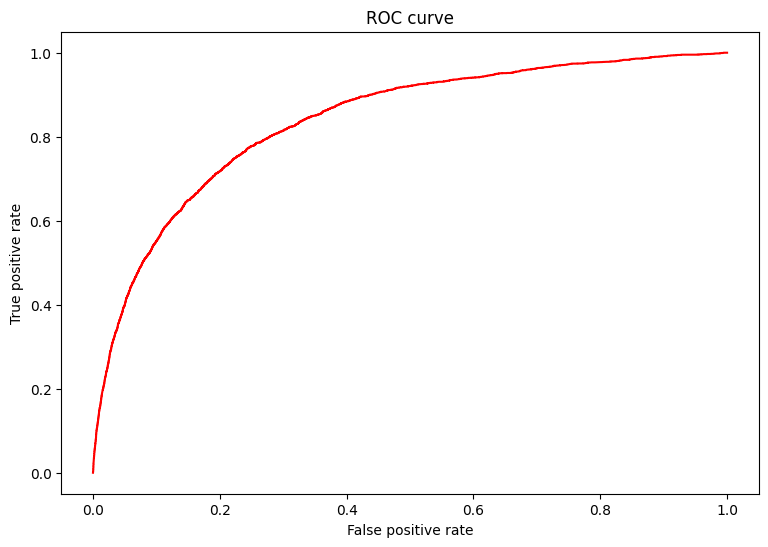

In [47]:
plot_roc_curve(clf, X_test, y_test)

### 5. Create submission to Kaggle

In [48]:
predictions = clf.predict_proba(X_kaggle_test)[:, 1]

In [49]:
predictions.shape

(101503,)

In [50]:
# Save the predictions to a CSV file
sub = pd.read_csv('https://raw.githubusercontent.com/Astralex98/Give-me-some-credit-Kaggle-/main/sampleEntry.csv')
sub['Probability']=predictions
sub.to_csv('MyGBSubmission.csv', index=False)
sub

,Id,Probability
0,1,0.061130
1,2,0.020962
2,3,0.032693
3,4,0.066660
4,5,0.076080
...,...,...
101498,101499,0.020769
101499,101500,0.182649
101500,101501,0.017479
101501,101502,0.282562


As a result (if we train on full data) we will have:

**Public** score = 0.85957

**Private** score = 0.86458

**Task:** Try to improve results on current small data using different hyperparameters, models (Bagging, Random Forest, XGB, Log.reg), selecting optimal features and etc. At home you can try all this stuff on full data and create your own submission to Kaggle!